# gillespie_ssa Schlogl model tutorial

In [1]:
import matplotlib.pyplot as plt
from gillespie.gillespie import gillespie_ssa

In [2]:
# data for Schogle model |  WORKING!!!!!!!!!!!!!!!!!!!!!!
# Paper: NUMERICAL SOLUTION OF STOCHASTIC MODELS OF BIOCHEMICAL KINETICS
# Authors: SILVANA ILIE, WAYNE H. ENRIGHT AND KENNETH R. JACKSON

# Quantities for reagents a,b,x
reag_quant = [100000, 200000, 250]
# reaction stoichiometries
state_change_vect = [[-1, 0, +1],
                     [+1, 0, -1],
                     [0, -1, +1],
                     [0, +1, -1]]
# reaction combinatorics (including reaction constants)
combinatorics = [lambda a,b,x : (3*10e-8*a*x*(x-1)/2),
                lambda a,b,x : (0.0001*x*(x-1)*(x-2)/6),
                lambda a,b,x : b*0.001,
                lambda a,b,x : x*3.5]

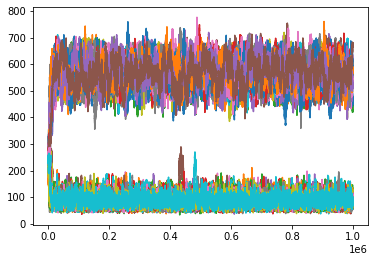

In [3]:
result_dict ={}
for epoch in range(50):
    
    a = gillespie_ssa(reagent_quantity=reag_quant,
                      state_change_vectors=state_change_vect,
                      combinatorics=combinatorics,
                      iteration=100000,
                      set_fixed_reagents=[0,1])
    result_dict[epoch] = [a.timestep_list, a.molecular_species_history]
    plt.plot([x for x in range(a.actual_iteration+1)],[y[2] for y in a.molecular_species_history])